# Prepare the Dataset

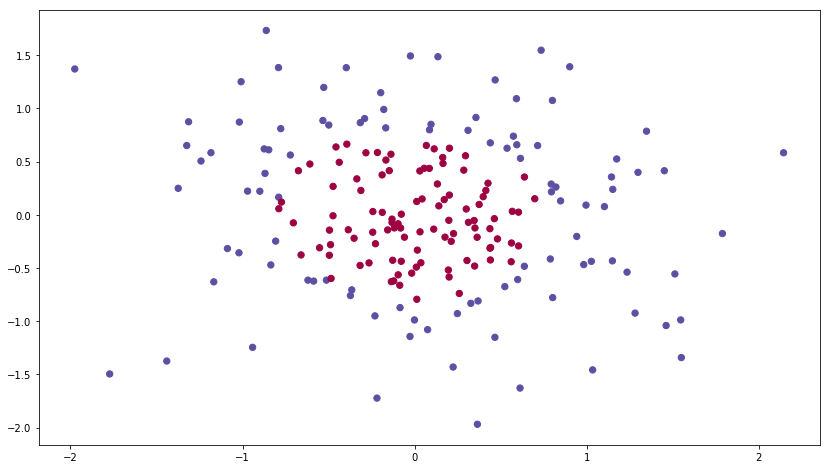

In [1]:
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

from datetime import datetime

data = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=200, 
                                              n_features=2, n_classes=2, 
                                              shuffle=True, random_state=1)

X, Y = data
X, Y = X.T, Y.reshape(1, Y.shape[0])

# Visualize the data
f = plt.figure(figsize=(14,8))
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral)
plt.show()

In [2]:
def get_meshgrid(X, y):
    """
    A helper function for us to plot the decision boundaries
    
    Originally from Andrew Ng's Deep Learning Specialisation Course
    """
    
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    return xx, yy

# Reference Network (pyTorch)

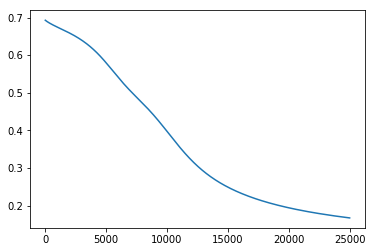

Time taken: 0:00:04.277607


In [3]:
import torch
from torch import nn
from torch import optim
from torch import tensor

tss = datetime.now()
# Create Tensors to hold inputs and outputs
# Note that the pyTorch inputs are of size (num_training_examples, input_size) which are the opposite to our network
# So, we just translate the results
x = tensor(X.T).type(torch.float)
y = tensor(Y.T).type(torch.float)

# Use the nn package to a basic model and binary cross entropy loss function.
model = nn.Sequential(
    nn.Linear(2, 5),
    nn.Tanh(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()

# Use the optim package to define an SGD Optimizer that will update the weights of
# the model for us.
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
costs = []

# Initialise the model parameters as a uniform normal distribution
for layer in model:
    if layer.type == nn.Linear:
        layer.weight = nn.init.normal_(layer.weight)

# Train for 25,000 epochs.
for t in range(25000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    cost = loss_fn(y_pred, y)
    costs.append(cost.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    cost.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

# Plot the cost over training.
plt.plot(costs)
plt.show()

print('Time taken: {}'.format(datetime.now() - tss))

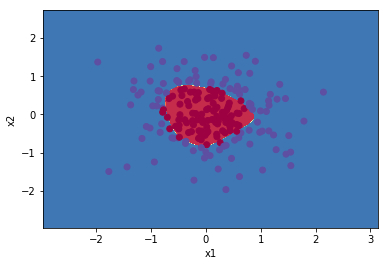

In [4]:
xx, yy = get_meshgrid(X, Y)

# Predict the function value for the whole grid
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).type(torch.float))
Z = Z.reshape(xx.shape).data.numpy()
Z[Z > 0.5] = 1
Z[Z < 0.5] = 0

# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), cmap=plt.cm.Spectral)
plt.show()

In [5]:
# Calculate prediction accuracy
pred = model(x).data.numpy()
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

acc = len(pred[pred == Y.T]) / len(pred) * 100
print('Accuracy: {}%'.format(acc))

Accuracy: 95.5%


# Test Network (Potatolemon)

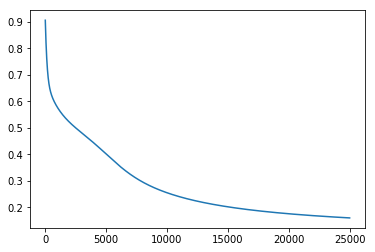

Time taken: 0:00:08.106861


In [6]:
import sys
sys.path.insert(0, '../')

from src import network

tss = datetime.now()

# Set up our network, specifying input dimensions and hidden layers
plnn = network.Network(2, [5], learning_rate=0.01, activation=network.tanh)

# Initialise layer weights using a random uniform scheme
for layer in plnn.layers:
    layer.set_weights(np.random.standard_normal(layer.get_weights().shape))

# Fit our network
costs = plnn.fit(X, Y, epochs=25000, verbose=False)

# Plot the costs
plt.plot(costs)
plt.show()

print('Time taken: {}'.format(datetime.now() - tss))

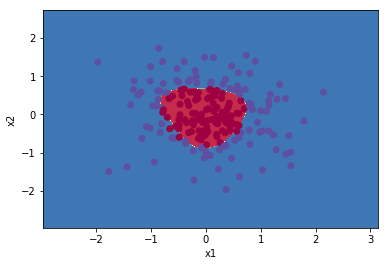

In [7]:
xx, yy = get_meshgrid(X, Y)

# Predict the function value for the whole grid
Z = plnn.predict(np.c_[xx.ravel(), yy.ravel()].T)
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), cmap=plt.cm.Spectral)
plt.show()

In [8]:
# Calculate prediction accuracy
pred = plnn.predict(X)

acc = len(pred[pred == Y]) / len(pred.T) * 100
print('Accuracy: {}%'.format(acc))

Accuracy: 96.0%
